# Solving the Schrödinger Equation for the Quantum Harmonic Oscillator

In this example, we are going to solve the stationary Schrödinger equation, which is an eigenvalue problem of the Hamiltonian differential operator. That is, we are solving

$$
H \psi = E \psi
$$

where $E$ are the allowed eigenvalues, $\psi$ are the allowed eigenvectors/eigenfunctions and $H$ is 
the differential operator

$$
H = -\frac{1}{2}\frac{d^2}{dx^2} + \frac{1}{2}  x^2
$$

There are different ways how one can address this problem, but for the sake of this example, we will use *numgrids* capability to represent differential operators as matrices.

In [102]:
from numgrids import *

Define a 1D grid with 100 grid points from -10 to 10:

In [103]:
N = 100
grid = Grid(Axis(AxisType.EQUIDISTANT, N, -10, 10))

In [104]:
x = grid.coords

The kinetic energy part of the Hamiltonian is

In [105]:
T = - 0.5 * Diff(grid, 2, 0).as_matrix()

where we have converted the partial derivative into its matrix representation by calling the `as_matrix` method. Note that this returns a *scipy* sparse matrix type:

In [106]:
T

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 504 stored elements in Compressed Sparse Row format>

For the 1D case, the spare matrix type is not really meaningful, but for multidimensional cases, it becomes imperative.

The potential energy part of $H$, expressed as a matrix is:

In [107]:
import scipy

V = scipy.sparse.diags(0.5 * x**2)

So $H$ is simply

In [108]:
H = T + V
type(H)

scipy.sparse._csr.csr_matrix

Since $H$ has the type of a *scipy* sparse matrix, we can use the `scipy.sparse.linalg` subpackage of *scipy* to solve the eigenvalue problem. We are only interested in the spectrum near the ground state (lowest eigenvalues, option "SR"):

In [109]:
from scipy.sparse.linalg import eigs
eigvals, eigvecs = eigs(H, k=8, which="SR")

The eigenvalues are

In [110]:
eigvals

array([0.49998286+0.j, 1.49988046+0.j, 2.49957483+0.j, 3.49893355+0.j,
       4.49782704+0.j, 5.4961283 +0.j, 6.49371269+0.j, 7.49045773+0.j])

which you probably recognize as the spectrum of the quantum harmonic oscillator.

Finally, let's plot the eigenvectors, i.e. the eigenstates of the quantum system:

In [111]:
eigvecs.shape

(100, 8)

Text(0, 0.5, '$\\psi(x)$')

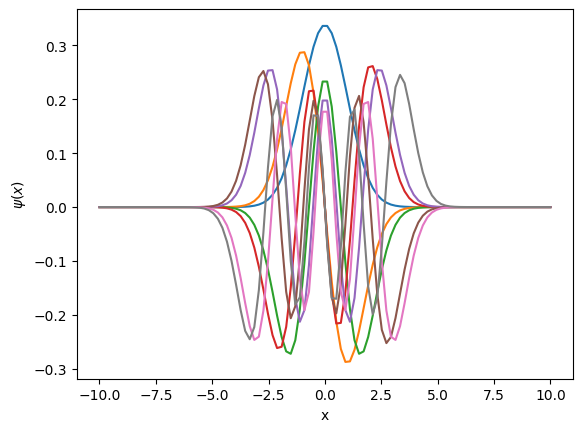

In [112]:
import matplotlib.pyplot as plt


for n, psi in enumerate(eigvecs.T):
    plt.plot(x, np.real(psi))
    
plt.xlabel("x")
plt.ylabel(r"$\psi(x)$")